In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.animation import FuncAnimation

from swarm_sim import *

%matplotlib inline 

In [12]:
#PATH = '\Traces.csv'
#satellites = {}

#for i in range(0,100):
#    df = pd.read_csv(PATH+str(i)+'.csv', sep=',', header=0)
#    df['coords'] = ['x','y','z']
#    satellites[i] = df.set_index('coords', drop=True)
    
#DURATION = 2000
#NB_NODES = 100

#satellites[0].head()

import pandas as pd

PATH = 'Traces.csv'  # Assurez-vous que le chemin est correct
DURATION = 2000
NB_NODES = 100

# Lecture du fichier CSV (sans header)
df = pd.read_csv(PATH, sep=',', header=None)

# Restructuration pour avoir un DataFrame par satellite, avec des colonnes nommées '0', '1', ..., '1999'
satellites = {}

for i in range(NB_NODES):
    # Extraction des 3 lignes (x, y, z) pour le satellite i
    start_idx = 3 * i
    
    if start_idx + 2 >= len(df):
        x = df.iloc[start_idx].values
        y = df.iloc[start_idx + 1].values if start_idx + 1 < len(df) else [0] * DURATION
        z = [0] * len(x)  # Valeurs par défaut si manquantes
    else:
        x = df.iloc[start_idx].values
        y = df.iloc[start_idx + 1].values
        z = df.iloc[start_idx + 2].values
    
    # Création d'un DataFrame où chaque colonne est un pas de temps ('0', '1', ..., '1999')
    satellite_df = pd.DataFrame({
        'x': x,
        'y': y,
        'z': z
    }).T  # Transposition pour avoir les temps en colonnes
    
    # Renommage des colonnes en chaînes de caractères ('0', '1', ..., '1999')
    satellite_df.columns = satellite_df.columns.astype(str)
    
    satellites[i] = satellite_df

# Vérification du format
print(satellites[0])  # Doit afficher x, y, z en index et '0', '1', ... en colonnes

              0             1             2             3             4  \
x -4.850747e+05 -4.937755e+05 -5.024536e+05 -5.111086e+05 -5.197401e+05   
y -7.066530e+05 -7.201117e+05 -7.335372e+05 -7.469290e+05 -7.602864e+05   
z -2.026363e+06 -2.019625e+06 -2.012795e+06 -2.005871e+06 -1.998855e+06   

              5             6             7             8             9  ...  \
x -5.283476e+05 -5.369309e+05 -5.454894e+05 -5.540229e+05 -5.625310e+05  ...   
y -7.736088e+05 -7.868957e+05 -8.001464e+05 -8.133603e+05 -8.265368e+05  ...   
z -1.991747e+06 -1.984548e+06 -1.977257e+06 -1.969876e+06 -1.962403e+06  ...   

           9990          9991          9992          9993          9994  \
x  1.490967e+06  1.494274e+06  1.497573e+06  1.500865e+06  1.504149e+06   
y  2.218138e+06  2.223313e+06  2.228477e+06  2.233629e+06  2.238769e+06   
z  3.692429e+06  3.686602e+06  3.680756e+06  3.674890e+06  3.669006e+06   

           9995          9996          9997          9998          9999  
x  

In [13]:
swarm_data = {}

with tqdm(total = DURATION, desc = 'Converting to Swarm') as pbar:
    for t in range(DURATION):
        swarm_data[t] = Swarm(
            connection_range=30000, 
            nodes=[Node(id, node[str(t)].x, node[str(t)].y, node[str(t)].z) for id,node in satellites.items()]
            )
        pbar.update(1)

print(swarm_data[0])

Converting to Swarm: 100%|██████████████████| 2000/2000 [00:25<00:00, 78.29it/s]

Swarm of 100 node(s), connection range: 30000


In [14]:
def compute_neighbor_matrix(swarm_chunk, connection_range=None):
    neighbor_matrix = {}
    with tqdm(total=len(swarm_chunk.keys()), desc='Computing Neighbor matrix') as pbar:
        for t,swarm in swarm_chunk.items():
            neighbor_matrix[t] = swarm.neighbor_matrix(connection_range)
            pbar.update(1)
    return neighbor_matrix

def compute_swarm_degree(swarm_chunk):
    swarm_degree = {}
    with tqdm(total=len(swarm_chunk.keys()), desc='Computing Swarm degree') as pbar:    
        for t,swarm in swarm_chunk.items():
            swarm_degree[t] = swarm.degree()
            pbar.update(1)
    return swarm_degree

def init_network(swarm_chunk, cr=None):
    if not cr:
        cr = swarm_chunk[0].connection_range
    print('\nConnection range:', cr)
    neighbor_matrix = compute_neighbor_matrix(swarm_chunk, connection_range=cr)
    swarm_degree = compute_swarm_degree(swarm_chunk)
    sum_data = [e for t in swarm_degree.keys() for e in swarm_degree[t]]
    print('Minimum number of neighbors:', np.min(sum_data))
    print('Maximum number of neighbors:', np.max(sum_data))
    print('Average number of neighbors:', np.mean(sum_data))
    node_ict = []
    for i in range(NB_NODES):
        node_data = [swarm_degree[t][i] for t in swarm_degree.keys()]
        node_ict.append(node_data.count(0) / float(len(swarm_chunk.keys()))*100)
    mean_ict = np.mean(node_ict)
    print('Mean inter-contact time:', mean_ict)

In [15]:
init_network(swarm_data)


Connection range: 30000


Computing Swarm degree: 100%|████████████| 2000/2000 [00:00<00:00, 25217.97it/s]


Minimum number of neighbors: 0
Maximum number of neighbors: 28
Average number of neighbors: 8.30288
Mean inter-contact time: 9.0555


## Animate connectivity evolution (edges)

In [16]:
edges = {}

for t, swarm in swarm_data.items():
    edges[t] = []
    for node in swarm.nodes:
        for n in node.neighbors:
            edge = ([node.x, n.x], [node.y, n.y], [node.z, n.z])
            op = ([n.x, node.x], [n.y, node.y], [n.z, node.z])
            if op not in edges[t]:
                edges[t].append(edge)

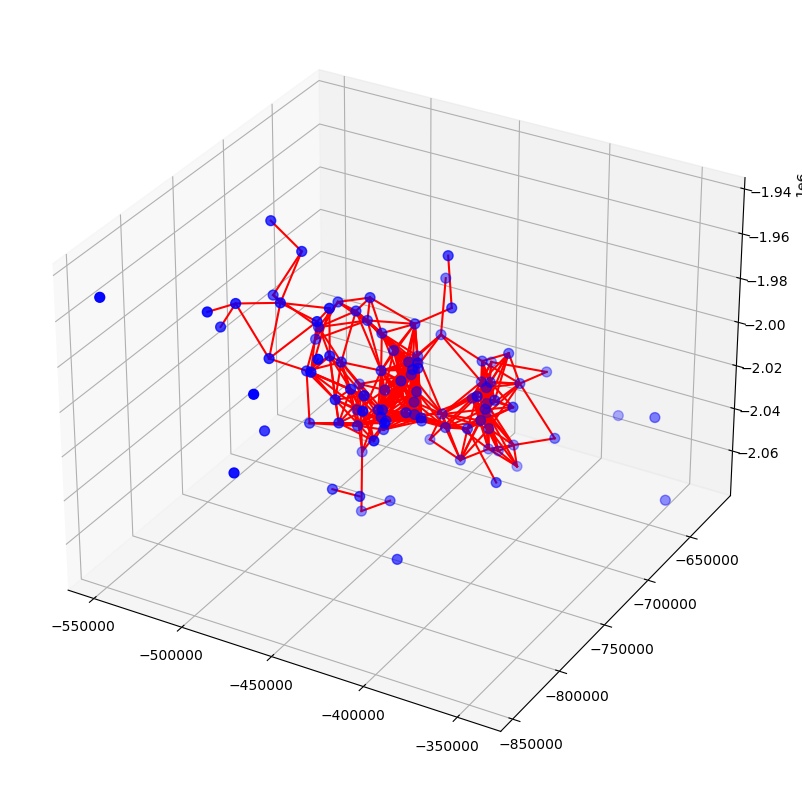

In [17]:
# Static image
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
t = 0

swarm = swarm_data[t]
x_data = [node.x for node in swarm.nodes]
y_data = [node.y for node in swarm.nodes]
z_data = [node.z for node in swarm.nodes]
ax.scatter(x_data, y_data, z_data, c='blue', s=50)

for edge in edges[t]:
    ax.plot(edge[0], edge[1], edge[2], c='red')

MovieWriter ffmpeg unavailable; using Pillow instead.


PermissionError: [Errno 13] Permission denied: '/swarm_edges_2000.png'

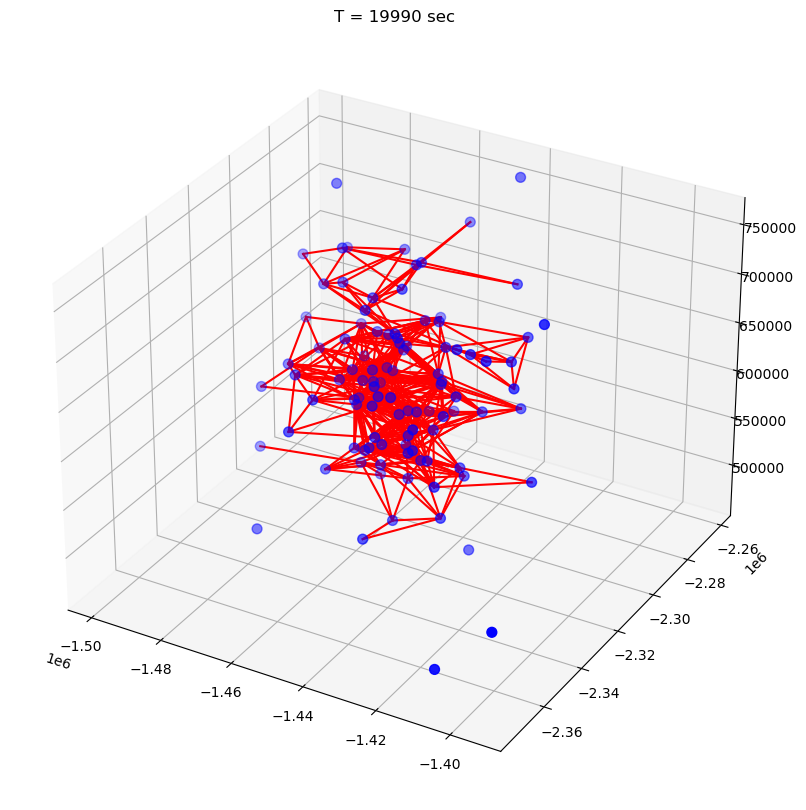

In [18]:
def animate(t):
    swarm = swarm_data[t]
    x_data = [node.x for node in swarm.nodes]
    y_data = [node.y for node in swarm.nodes]
    z_data = [node.z for node in swarm.nodes]
    ax.clear()
    time = t*10
    ax.set_title(f'T = {time} sec')
    ax.scatter(x_data, y_data, z_data, c='blue', s=50)
    for edge in edges[t]:
        ax.plot(edge[0], edge[1], edge[2], c='red')

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

x_data = []
y_data = []
z_data = []
    
anim = FuncAnimation(fig, animate, frames=len(swarm_data.keys()), interval=100, repeat=False)
anim.save('/swarm_edges_2000.png')